In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

In [2]:
# Download the data
import yfinance as yf

ewa = yf.download('EWA', start='2011-01-01', end='2019-12-23')['Adj Close']
ewc = yf.download('EWC', start='2011-01-01', end='2019-12-23')['Adj Close']

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [3]:
# The Hedge ratio calculated as in the video
beta = 0.951047175995611
a = 7.954900268580705

In [4]:
# Get the spread data
spread = ewc - beta*ewa - a
spread.index = pd.to_datetime(spread.index)
spread.head()

Date
2010-12-31    1.957815
2011-01-03    2.069307
2011-01-04    2.186375
2011-01-05    2.330948
2011-01-06    2.355568
Name: Adj Close, dtype: float64

In [5]:
ewc.head()

Date
2010-12-31    24.462849
2011-01-03    24.660135
2011-01-04    24.399721
2011-01-05    24.447065
2011-01-06    24.328701
Name: Adj Close, dtype: float64

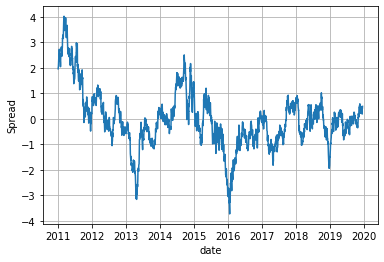

In [6]:
plt.plot(spread)
plt.xlabel("date")
plt.ylabel("Spread")
plt.grid()
plt.show()

## Ex 6.1

In the lecture, we set our trading signal, i.e., the threshold, to be $$0.5*std_{spread}$$ 

What if we increase this threshold to be $$1*std_{spread}$$

How would it affect our P&L curve?

In [7]:
thresh = np.std(spread)

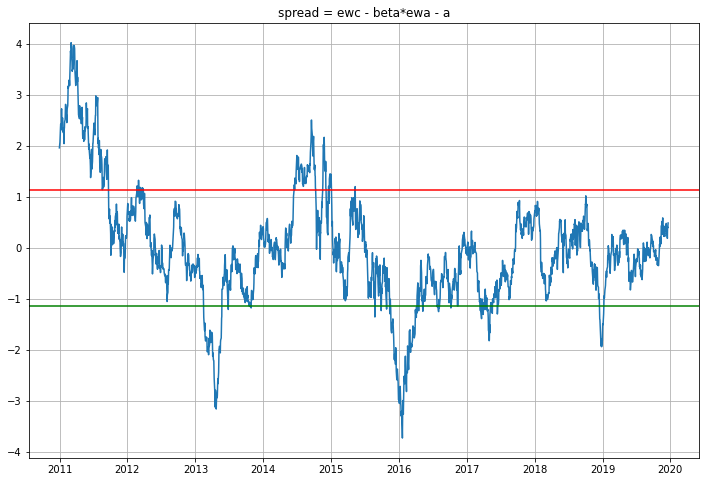

In [8]:
# Your answer
plt.figure(figsize=(12,8))
plt.title("spread = ewc - beta*ewa - a")
plt.plot(spread)
plt.axhline(y=thresh, color="r")
#plt.axhline(y=-thresh/2, color="r")
plt.axhline(y=-thresh, color="g")
#plt.axhline(y=thresh/3, color="g")
plt.grid()
plt.show()

In [9]:
# backtest
inpos, ewc_entry_price, ewc_exit_price, ewa_entry_price, ewa_exit_price = 0, 0, 0, 0, 0
total_pnl, ewc_pnl, ewa_pnl, pos, time_in_trade, exit_date, entry_date = [], [], [], [], [], [], []
open_time = datetime(2000,1,1)
############################################
# for loop through dates(spread.index); (aka go day-by-day)
# if spread[date] > thresh and inpos == 0: we short ewc and long ewa --> exit when spread == 0 SCENARIO-1
# if spread[date] < thresh and inpos == 0: we long ewc and shoet ewa --> exit when spread == 0 SCENARIO-2
# we always use 1 unit for both assets for every signal
init_cap = ewc[0] + ewa[0]
print(f"Initial Capital: {init_cap}")
for date in spread.index:
    
    if spread[date] >= thresh and inpos == 0: #scenario-1 entry signal
        ewc_entry_price = ewc[date] # short ewc
        inpos = -1
        open_time = date
        entry_date.append(open_time)
        ewa_entry_price = ewa[date] # long ewa

    elif spread[date] <= 0 and inpos==-1: #scenario-1 exit signal
        ewc_exit_price = ewc[date] # currently shorting
        ewa_exit_price = ewa[date] # currently longing
        time_in_trade.append((date - open_time).days)
        exit_date.append(date)
        ewc_p = ewc_entry_price - ewa_exit_price
        ewa_p = ewa_exit_price - ewa_entry_price
        ewc_pnl.append(ewc_p)
        ewa_pnl.append(ewa_p)
        total_pnl.append(ewa_p+ewc_p)
        inpos = 0
        print(f"Entry Date: {open_time}\nEWC short: {ewc_p} /EWA long: {ewa_p} \n Current total profit: {(sum(ewc_pnl))+(sum(ewa_pnl))}\n Closed Date: {date}\t Hold Period:{(date-open_time).days} days")
        print("*"*50)
    elif spread[date] <= -thresh and inpos == 0: #scenario-2 entry signal
        ewc_entry_price = ewc[date] # long ewc
        inpos = 1
        open_time = date
        entry_date.append(open_time)
        ewa_entry_price = ewa[date] # short ewa
    elif spread[date] >= 0 and inpos==1: #scenario-2 exit signal
        ewc_exit_price = ewc[date] # currently longing
        ewa_exit_price = ewa[date] # currently shorting
        time_in_trade.append((date - open_time).days)
        exit_date.append(date) 
        ewc_p = ewc_exit_price - ewc_entry_price # long
        ewa_p = ewa_entry_price - ewa_exit_price # short       
        ewc_pnl.append(ewc_p)
        ewa_pnl.append(ewa_p)
        total_pnl.append(ewa_p+ewc_p)
        inpos = 0
        print(f"Entry Date: {open_time}\nEWC long: {ewc_p} /EWA short: {ewa_p} \n Current total profit: {(sum(ewc_pnl))+(sum(ewa_pnl))}\n Closed Date: {date}\t Hold Period:{(date-open_time).days} days")
        print("*"*50)
    pos.append(inpos)
exit_cap = sum(ewc_pnl)+sum(ewa_pnl)+init_cap
print(f"Exit capital: {exit_cap} \nTotal profit:{(exit_cap-init_cap)/init_cap:.2%}")
print(f"Total num of trades: {len(exit_date)}")



Initial Capital: 39.76191425323486
Entry Date: 2010-12-31 00:00:00
EWC short: 12.325907707214355 /EWA long: -3.1621246337890625 
 Current total profit: 9.163783073425293
 Closed Date: 2011-10-04 00:00:00	 Hold Period:277 days
**************************************************
Entry Date: 2012-02-22 00:00:00
EWC short: 8.984136581420898 /EWA long: -0.5426645278930664 
 Current total profit: 17.605255126953125
 Closed Date: 2012-05-08 00:00:00	 Hold Period:76 days
**************************************************
Entry Date: 2013-02-14 00:00:00
EWC long: -0.37134742736816406 /EWA short: 1.6448898315429688 
 Current total profit: 18.87879753112793
 Closed Date: 2013-07-22 00:00:00	 Hold Period:158 days
**************************************************
Entry Date: 2013-10-17 00:00:00
EWC long: -0.1498851776123047 /EWA short: 1.428274154663086 
 Current total profit: 20.15718650817871
 Closed Date: 2013-12-09 00:00:00	 Hold Period:53 days
**************************************************

In [10]:
time_in_trade

[277, 76, 158, 53, 120, 55, 51, 454, 190, 46]

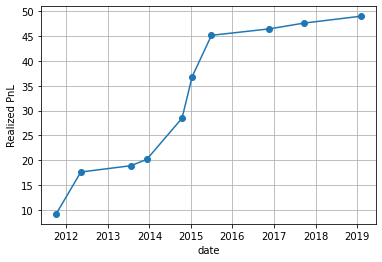

In [11]:
profit_per_trade = pd.Series(total_pnl)
profit_per_trade.index = exit_date

plt.plot(np.cumsum(profit_per_trade),'-o')
plt.xlabel('date')
plt.ylabel('Realized PnL')
plt.grid()
plt.show()


In [12]:
# unreailzed PnL
pos1 = [0] + pos # 0 for the first day
ewa_ewc_diff = ewa.diff() + ewc.diff()
daily_pnl = ewa_ewc_diff*pos1[:-1]


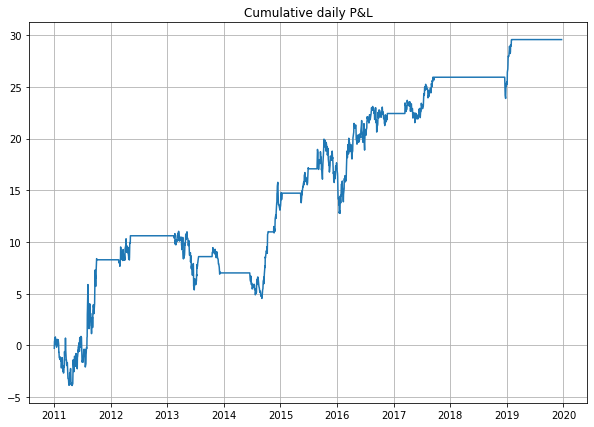

In [13]:
# Cumulative daily P&L
cum_daily_pnl = np.cumsum(daily_pnl)

plt.figure(figsize=(10,7))
plt.plot(cum_daily_pnl)
plt.title('Cumulative daily P&L')
plt.grid()
plt.show()

In [14]:
def plot_2figs(data1, data2, label_1, label_2):
    fig=plt.figure(figsize=(10,6))
    ax=fig.add_subplot(111, label="1")
    ax2=fig.add_subplot(111, label="2", frame_on=False)

    ax.plot(data1, color='k')
    ax.set_xlim(data1.index.min(), data1.index.max())
    #ax.set_ylim(-3, 20)
    ax.grid()
    ax.set_ylabel(label_1, fontsize=14)

    ax2.plot(data2, 'go-')
    ax2.set_xlim(data1.index.min(), data1.index.max())
    #ax2.set_ylim(-3, 20)
    ax2.set_ylabel(label_2, color='g', fontsize=14)
    ax2.yaxis.set_label_position('right') 
    ax2.xaxis.tick_top()
    ax2.yaxis.tick_right()
    ax2.tick_params(colors="g")
    plt.show()

In [15]:
#cum_p_per_trade = np.cumsum(profit_per_trade)
#cum_p_per_trade["2011-10-04 "] - cum_daily_pnl["2011-10-04"]

In [16]:
#cum_daily_pnl += (cum_p_per_trade["2011-10-04 "] - cum_daily_pnl["2011-10-04"])

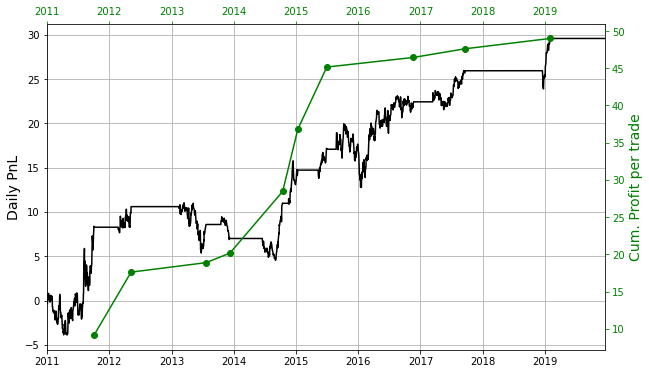

In [17]:
cum_p_per_trade = np.cumsum(profit_per_trade)
plot_2figs(cum_daily_pnl, cum_p_per_trade, 'Daily PnL', 'Cum. Profit per trade')

In [18]:
# somewhat somewhere, I am wrong! Idk where?

## Ex 6.2
We will incorporate the trading cost now into our backtest. This will again affect the performance of our trading strategy. 

Assume our commision is 5 basis points. What would the optimum threshold be (i.e., to maximise our cumulative realised P&L)?

__Hint:__

The trading cost can be calculated as $$T = (ewc + beta*ewa)*c,$$
where c is the commision. 

Then the profit per trade can be calculated using $$(spread_{t+1} - spread_{t}) - (T_{t+1} + T_{t}).$$

In [19]:
# Your answer
commission = 0.5/100

entry_comm_paid = commission * (ewa[entry_date] + ewc[entry_date])
exit_comm_paid = commission * (ewa[exit_date] + ewc[exit_date])
exit_comm_paid
total_comm_paid = []
for row in zip(entry_comm_paid, exit_comm_paid):
    total_comm_paid.append(sum(row))
total_comm_paid

pnl_comm_incl = [total_pnl[i] - total_comm_paid[i] for i in range(len(total_pnl))]
pnl_comm_incl

[8.8075315284729,
 8.07235391139984,
 0.8671328449249267,
 0.8635783576965332,
 7.859973382949829,
 7.947239465713501,
 7.940963935852051,
 0.9307648992538452,
 0.7317965412139893,
 0.9641144561767578]

In [20]:
print(sum(pnl_comm_incl), sum(total_pnl))

44.98544932365417 48.99480152130127


## Bonus section

What happens if our commission rate is different, i.e., 10 basis points, 15 basis points, etc.? How does it affect our P&L?

In [21]:
# Your answer

# just change the commission and run the code block...